In [1]:
import numpy as np

def rmse(y, yhat):
    return np.sqrt(np.mean((y.flatten() - yhat.flatten())**2))

In [2]:
n_splits = 5 # cross-fitting and cross-validation splits
data = '401k' # which dataset, one of {'401k', 'criteo', 'welfare', 'poverty', 'star'}
xfeat = 'inc' # feature to use as x axis in plotting, e.g. for criteo 'f1', for 401k 'inc', for welfare 'polviews'
hetero_feats = ['inc'] # list of subset of features to be used for CATE model or the string 'all' for everything

## For semi-synthetic data generation
semi_synth = False # Whether true outcome y should be replaced by a fake outcome from a known CEF
simple_synth = False # Whether the true CEF of the fake y should be simple or fitted from data
max_depth = 3 # max depth of random forest during for semi-synthetic model fitting
scale = .1 # magnitude of noise in semi-synthetic data
def simple_true_cef(D, X): # simple CEF of the outcome for semi-synthetic data
    return .5 * np.array(X)[:, 1] * D + np.array(X)[:, 1]

In [3]:
from datasets import fetch_data_generator
np.random.seed(123)
get_data, abtest, true_cef, true_cate = fetch_data_generator(data=data, semi_synth=semi_synth,
                                                             simple_synth=simple_synth,
                                                             scale=scale, true_f=simple_true_cef,
                                                             max_depth=max_depth)
X, D, Y, groups = get_data()

In [4]:
if semi_synth:
    true_ate = np.mean(true_cate(X))
    print(f'True ATE: {true_ate}')

True ATE: 5010.33151975673


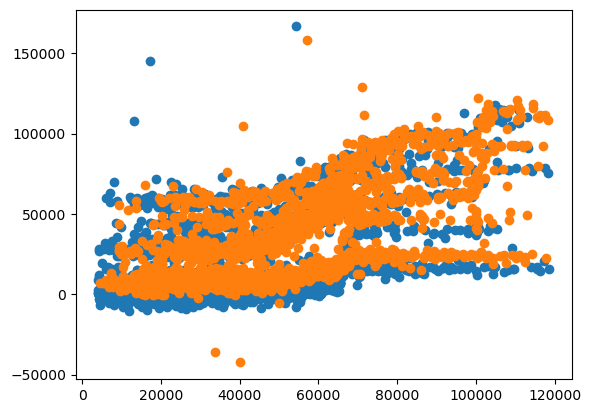

In [5]:
import matplotlib.pyplot as plt

plt.scatter(X[D==0]['inc'], Y[D==0])
plt.scatter(X[D==1]['inc'], Y[D==1])
plt.show()

In [6]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier

param_grid = {
    'max_depth': [2, 5, 9],
    'min_samples_leaf': [50, 100]
}
reg = lambda: GridSearchCV(RandomForestRegressor(random_state=123), param_grid)

param_grid = {
    'max_depth': [2, 5, 9],
    'min_samples_leaf': [10, 50, 100]
}
clf = lambda: GridSearchCV(RandomForestClassifier(random_state=123), param_grid)

In [7]:
from xgboost import XGBRegressor, XGBClassifier
from sklearn.model_selection import train_test_split
import xgboost as xgb

class MyXGBRegressor(XGBRegressor):
    
    def fit(self, X, y, sample_weight=None):
        if sample_weight is None:
            X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2)
            super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        else:
            X, Xval, y, yval, sample_weight, sample_weight_val = train_test_split(X, y, sample_weight,
                                                                                  shuffle=True, test_size=.2)
            super().fit(X, y, sample_weight=sample_weight,
                        eval_set=[(Xval, yval)], sample_weight_eval_set=[sample_weight_val], verbose=False)
        return self

class MyXGBClassifier(XGBClassifier):
    
    def fit(self, X, y):
        X, Xval, y, yval = train_test_split(X, y, shuffle=True, test_size=.2, stratify=y)
        super().fit(X, y, eval_set=[(Xval, yval)], verbose=False)
        return self

reg = lambda: MyXGBRegressor(max_depth=2, learning_rate=.05, n_estimators=500,
                             early_stopping_rounds=5, min_child_weight=20,
                             verbosity=0, random_state=123)
clf = lambda: MyXGBClassifier(max_depth=2, learning_rate=.05, n_estimators=500,
                              early_stopping_rounds=5, min_child_weight=20, verbosity=0,
                              random_state=123)

In [8]:
Z = X.values
Z, Zval, D, Dval, Y, Yval = train_test_split(Z, D, Y, test_size=.6)
Zval, Ztest, Dval, Dtest, Yval, Ytest = train_test_split(
Zval, Dval, Yval, test_size=.5)

In [9]:
g0 = reg().fit(Z[D==0], Y[D==0])
g1 = reg().fit(Z[D==1], Y[D==1])

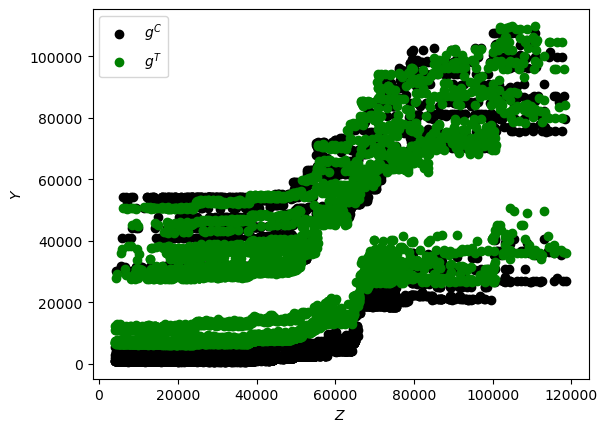

In [10]:
plt.scatter(X[xfeat], g0.predict(X.values), color='black', label='$g^C$')
plt.scatter(X[xfeat], g1.predict(X.values), color='green', label='$g^T$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [11]:
# propensity
mu = clf().fit(Z, D)

In [12]:
# X-learner
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0])
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]))

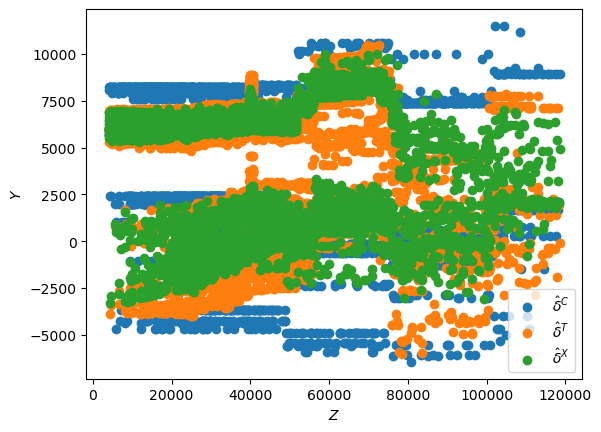

In [13]:
t0 = tau0.predict(X.values)
t1 = tau1.predict(X.values)
m = mu.predict_proba(X.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.scatter(X[xfeat], t0,  label='$\hat{\delta}^C$')
plt.scatter(X[xfeat], t1, label='$\hat{\delta}^T$')
plt.scatter(X[xfeat], tX,  label='$\hat{\delta}^X$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [14]:
import pandas as pd
grid = np.unique(np.percentile(X[xfeat], np.arange(0, 105, 5)))
Zgrid = pd.DataFrame(np.tile(np.median(X, axis=0, keepdims=True), (len(grid), 1)),
                    columns=X.columns)
Zgrid[xfeat] = grid

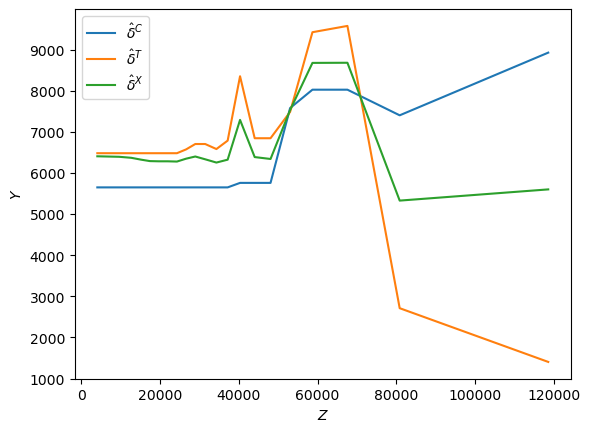

In [15]:
t0 = tau0.predict(Zgrid.values)
t1 = tau1.predict(Zgrid.values)
m = mu.predict_proba(Zgrid.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(grid, t0,  label='$\hat{\delta}^C$')
plt.plot(grid, t1, label='$\hat{\delta}^T$')
plt.plot(grid, tX,  label='$\hat{\delta}^X$')
plt.xlabel('$Z$')
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [16]:
# S-Learner
g = reg().fit(np.hstack([D.reshape(-1, 1), Z]), Y)

In [17]:
# IPS-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauIPS = reg().fit(Z, Y * (D - m)/cov)

In [18]:
# DR-Learner
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1.predict(Z)
g0preds = g0.predict(Z)
gpreds = g1preds * D + g0preds * (1 - D)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDR = reg().fit(Z, Ydr)

In [19]:
# R-Learner
h = reg().fit(Z, Y)
Yres = Y - h.predict(Z)
Dres = D - mu.predict_proba(Z)[:, 1]

In [20]:
DresClip = np.clip(Dres, 1e-12, np.inf) * (Dres >= 0) + np.clip(Dres, -np.inf, -1e-12) * (Dres<0)
tauR = reg().fit(Z, Yres/DresClip, sample_weight=Dres**2)

In [21]:
# from econml.grf import CausalForest
# tauR = CausalForest(min_samples_leaf=20, max_depth=5, max_samples=.8, inference=False).fit(Z, Dres, Yres)

In [22]:
# DRX-Learner
m = mu.predict_proba(Z)[:, 1]
g0preds = g0.predict(Z)
g1preds = g1.predict(Z)
g0preds = g0preds * (1 - m) + (g1.predict(Z) - tau0.predict(Z)) * m
g1preds = g1preds * m + (g0.predict(Z) + tau1.predict(Z)) * (1 - m)
gpreds = g1preds * D + g0preds * (1 - D)
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = (Y - gpreds) * (D - m)/cov + g1preds - g0preds
tauDRX = reg().fit(Z, Ydr)

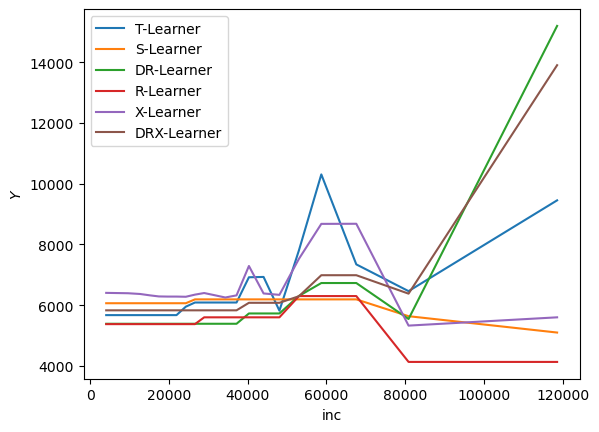

In [23]:
t0 = tau0.predict(Zgrid.values)
t1 = tau1.predict(Zgrid.values)
tT = g1.predict(Zgrid.values) - g0.predict(Zgrid.values)
tS = g.predict(np.hstack([np.ones(Zgrid.shape[0]).reshape(-1, 1), Zgrid.values])) 
tS -= g.predict(np.hstack([np.zeros(Zgrid.shape[0]).reshape(-1, 1), Zgrid.values]))
tIPS = tauIPS.predict(Zgrid.values)
tDR = tauDR.predict(Zgrid.values)
tR = tauR.predict(Zgrid.values)
m = mu.predict_proba(Zgrid.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Zgrid.values)

plt.plot(grid, tT, label=f'T-Learner')
plt.plot(grid, tS, label=f'S-Learner')
# plt.plot(grid, tIPS, label='IPS-Learner')
plt.plot(grid, tDR, label=f'DR-Learner')
plt.plot(grid, tR, label=f'R-Learner')
plt.plot(grid, tX,  label=f'X-Learner')
plt.plot(grid, tDRX, label=f'DRX-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

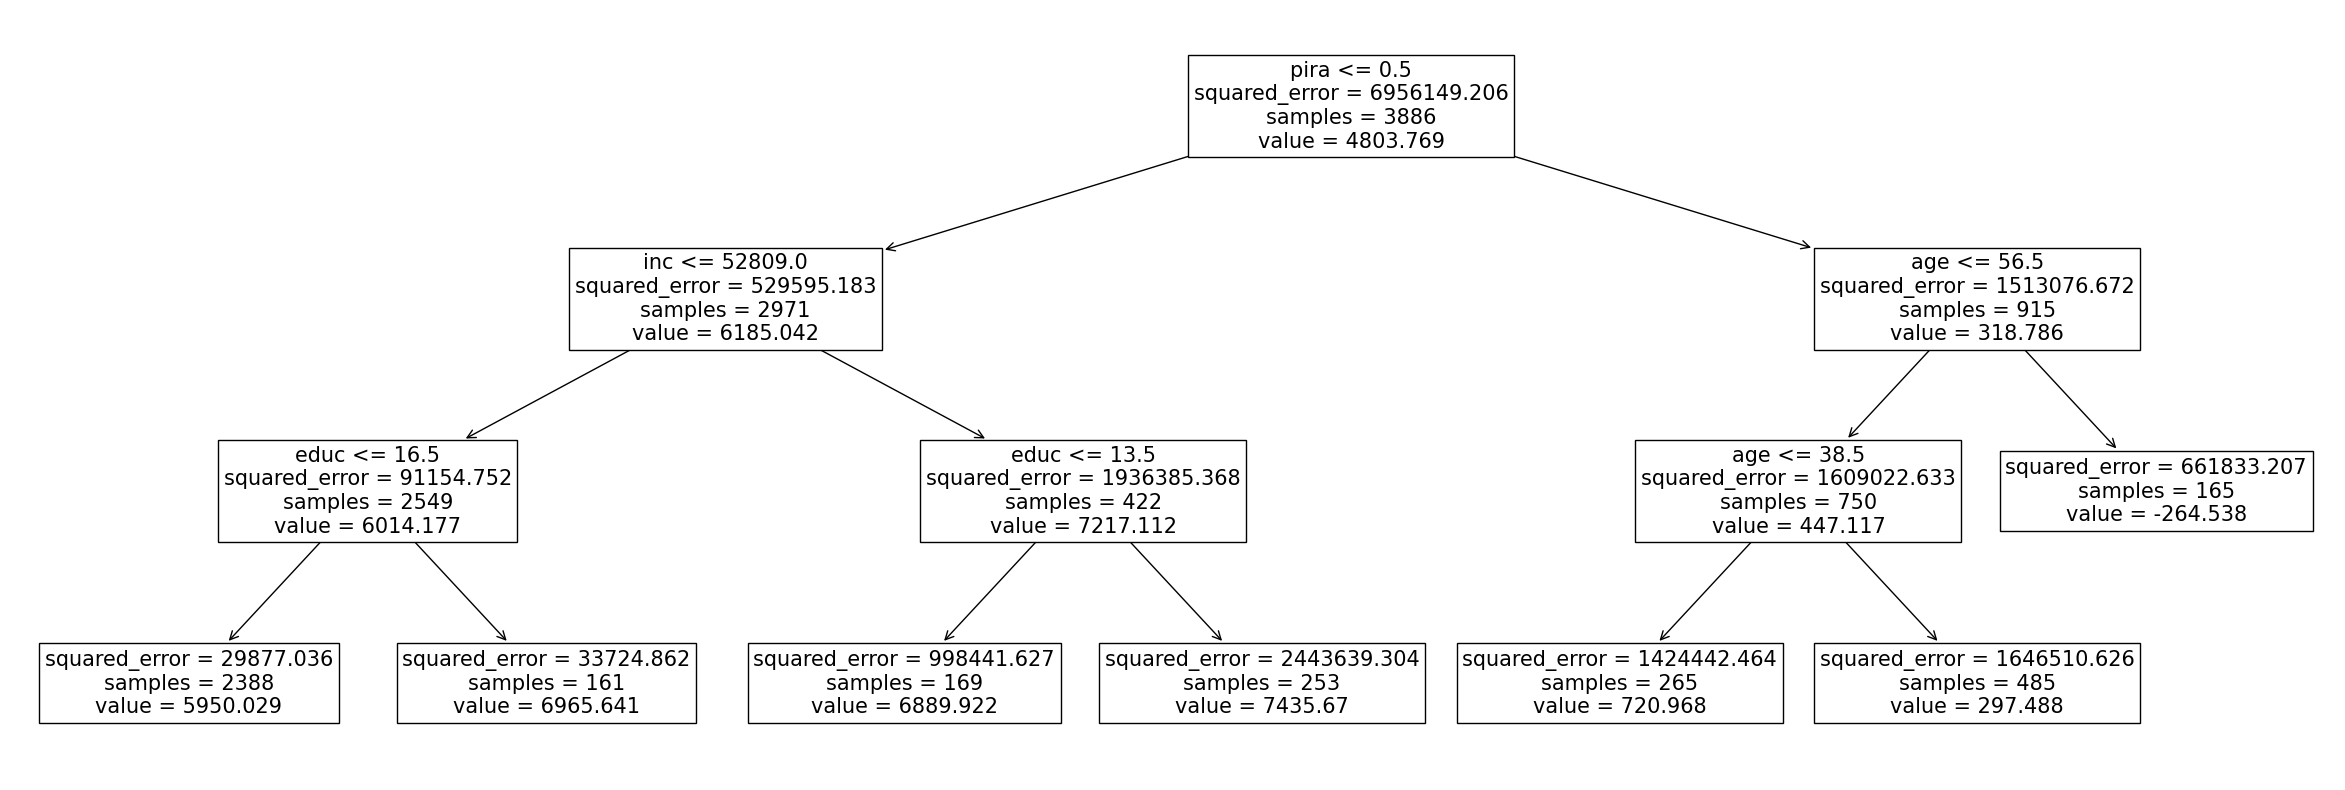

In [24]:
from sklearn.tree import DecisionTreeRegressor, plot_tree

Zdf = pd.DataFrame(Z, columns=X.columns)
tree = DecisionTreeRegressor(max_depth=3, min_samples_leaf=100).fit(Zdf, tauDRX.predict(Z))
plt.figure(figsize=(30, 10))
plot_tree(tree, feature_names=X.columns, fontsize=15)
plt.show()

In [25]:
import shap

explainer = shap.Explainer(tauDRX)
shap_values = explainer.shap_values(Zdf)

ntree_limit is deprecated, use `iteration_range` or model slicing instead.


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


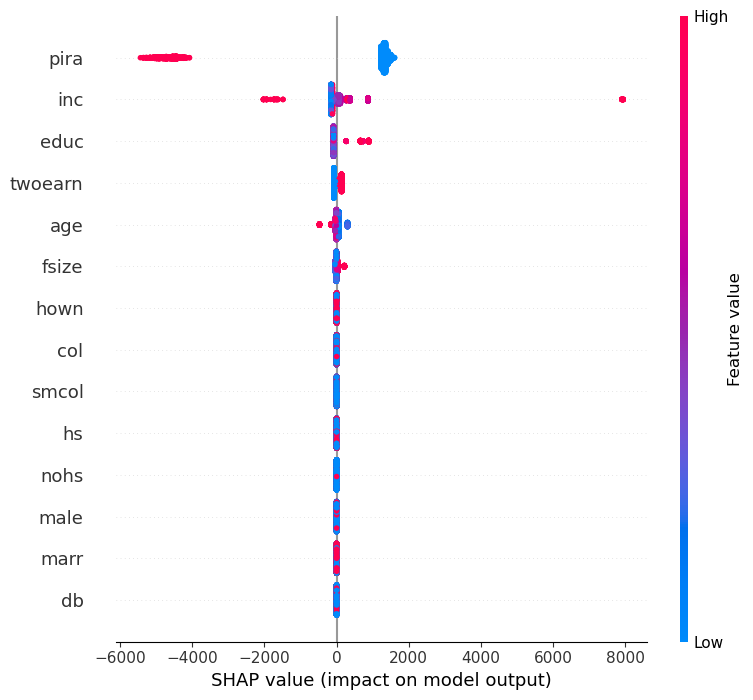

In [26]:
shap.summary_plot(shap_values, Zdf)

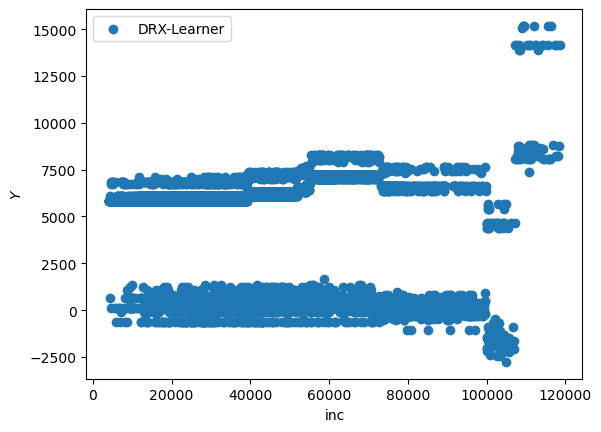

In [27]:
tDRX = tauDRX.predict(X.values)

plt.scatter(X[xfeat], tDRX, label=f'DRX-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

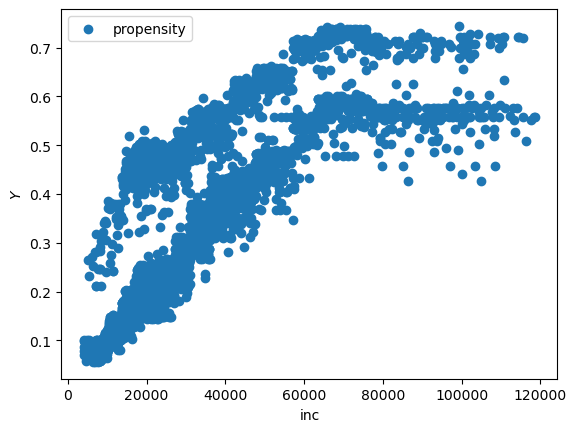

In [28]:
m = mu.predict_proba(Z)[:, 1]
plt.scatter(Zdf[xfeat], m, label=f'propensity')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

# Model Selection

In [29]:
import scipy

def instance(nu, U, y):
    n = y.shape[0]
    ploss = np.mean((y.reshape(1, -1) - U)**2, axis=1)

    def loss(x):
        return np.mean((y - U.T @ x)**2)

    def qfunction(x):
        return (1 - nu) * loss(x) + nu * x @ ploss

    def grad_q(x):
        return - 2 * (1 - nu) * U @ (y - U.T @ x) / n + nu * ploss

    return loss, qfunction, grad_q, ploss

def opt(K, qfunction, grad_q):
    res = scipy.optimize.minimize(qfunction, np.ones(K)/K, jac=grad_q, bounds=[(0, 1)]*K,
                                  constraints=scipy.optimize.LinearConstraint(np.ones((1, K)), lb=1, ub=1),
                                  tol=1e-12)
    return res.x

def qagg(F, y):
    scale = max(np.max(np.abs(F)), np.max(np.abs(y)))
    loss, qfunction, grad_q, ploss = instance(.5, F.T / scale, y / scale)
    return opt(F.shape[1], qfunction, grad_q)

In [30]:
# DR-Learner
m = mu.predict_proba(Zval)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1.predict(Zval)
g0preds = g0.predict(Zval)
gpreds = g1preds * Dval + g0preds * (1 - Dval)
Ydrval = (Yval - gpreds) * (Dval - m)/cov + g1preds - g0preds

In [31]:
t0 = tau0.predict(Zval)
t1 = tau1.predict(Zval)
tT = g1.predict(Zval) - g0.predict(Zval)
tS = g.predict(np.hstack([np.ones((Zval.shape[0], 1)), Zval]))
tS -= g.predict(np.hstack([np.zeros((Zval.shape[0], 1)), Zval]))
tIPS = tauIPS.predict(Zval)
tDR = tauDR.predict(Zval)
tR = tauR.predict(Zval)
m = mu.predict_proba(Zval)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Zval)

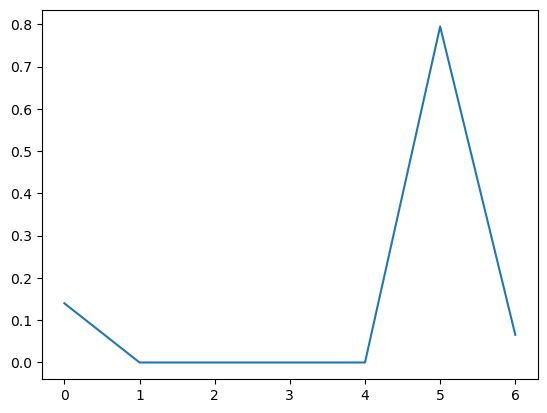

In [32]:
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
weights = qagg(F, Ydrval)
plt.plot(weights)

In [33]:
f'Ensemble: {rmse(true_cate(Zval), F @ weights):.4f}'

'Ensemble: 914.6704'

In [34]:
weightsBest = np.zeros(weights.shape)
weightsBest[np.argmin(np.mean((Ydrval.reshape(-1, 1) - F)**2, axis=0))] = 1.0
f'Ensemble: {rmse(true_cate(Zval), F @ weightsBest):.4f}'

'Ensemble: 928.7632'

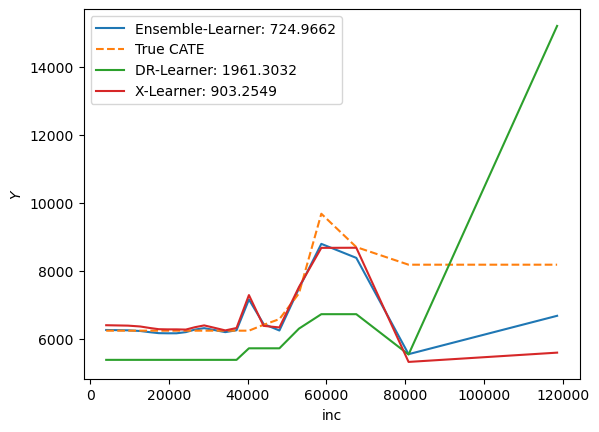

In [35]:
t0 = tau0.predict(Zgrid.values)
t1 = tau1.predict(Zgrid.values)
tT = g1.predict(Zgrid.values) - g0.predict(Zgrid.values)
tS = g.predict(np.hstack([np.ones(Zgrid.shape[0]).reshape(-1, 1), Zgrid.values])) 
tS -= g.predict(np.hstack([np.zeros(Zgrid.shape[0]).reshape(-1, 1), Zgrid.values]))
tIPS = tauIPS.predict(Zgrid.values)
tDR = tauDR.predict(Zgrid.values)
tR = tauR.predict(Zgrid.values)
m = mu.predict_proba(Zgrid.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Zgrid.values)
F = np.stack((tT, tS, tIPS, tDR, tR, tX, tDRX), -1)
tE = F @ weights

plt.plot(grid, tE, label=f'Ensemble-Learner: {rmse(true_cate(Zgrid), tE):.4f}')
plt.plot(grid, true_cate(Zgrid).flatten(), '--', label=f'True CATE')


plt.plot(grid, tDR, label=f'DR-Learner: {rmse(true_cate(Zgrid), tDR):.4f}')
plt.plot(grid, tX,  label=f'X-Learner: {rmse(true_cate(Zgrid), tX):.4f}')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [36]:
# DR-Learner
m = mu.predict_proba(Ztest)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
g1preds = g1.predict(Ztest)
g0preds = g0.predict(Ztest)
gpreds = g1preds * Dtest + g0preds * (1 - Dtest)
Ydrtest = (Ytest - gpreds) * (Dtest - m)/cov + g1preds - g0preds

# Other metalearner variants

In [35]:
m = mu.predict_proba(Z)[:, 1]
cov = np.clip(m * (1 - m), 1e-12, np.inf)
tauDRXW = reg().fit(Z, Ydr, sample_weight=cov**2)

[0]	validation_0-rmse:25343.89428
[1]	validation_0-rmse:24465.75870
[2]	validation_0-rmse:23643.88440
[3]	validation_0-rmse:22885.06908
[4]	validation_0-rmse:22171.18401
[5]	validation_0-rmse:21509.66589
[6]	validation_0-rmse:20895.62140
[7]	validation_0-rmse:20311.23177
[8]	validation_0-rmse:19765.12299
[9]	validation_0-rmse:19270.77225
[10]	validation_0-rmse:18802.78410
[11]	validation_0-rmse:18376.96002
[12]	validation_0-rmse:17980.82515
[13]	validation_0-rmse:17616.69968
[14]	validation_0-rmse:17275.15886
[15]	validation_0-rmse:16962.87316
[16]	validation_0-rmse:16678.45673
[17]	validation_0-rmse:16411.15545
[18]	validation_0-rmse:16165.95224
[19]	validation_0-rmse:15940.47237
[20]	validation_0-rmse:15734.59298
[21]	validation_0-rmse:15546.27467
[22]	validation_0-rmse:15372.89070
[23]	validation_0-rmse:15220.67773
[24]	validation_0-rmse:15080.45338
[25]	validation_0-rmse:14950.61108
[26]	validation_0-rmse:14834.00785
[27]	validation_0-rmse:14724.85939
[28]	validation_0-rmse:14625.4

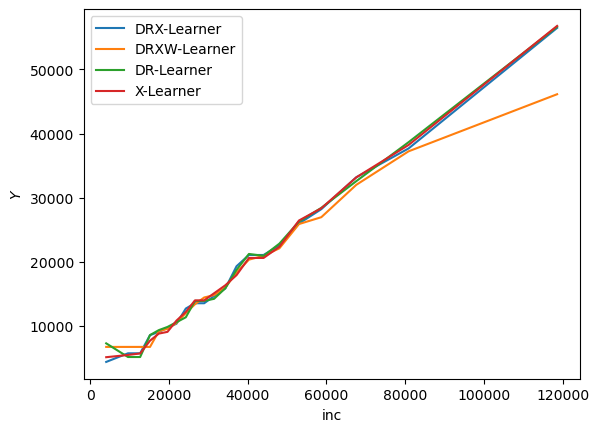

In [33]:
t0 = tau0.predict(Zgrid.values)
t1 = tau1.predict(Zgrid.values)
m = mu.predict_proba(Zgrid.values)[:, 1]
tDRX = tauDRX.predict(Zgrid.values)
tDRXW = tauDRXW.predict(Zgrid.values)
tX = t1 * (1 - m) + t0 * m
plt.plot(grid, tDRX, label=f'DRX-Learner')
plt.plot(grid, tDRXW, label=f'DRXW-Learner')
plt.plot(grid, tDR, label=f'DR-Learner')
plt.plot(grid, tX,  label=f'X-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [34]:
# post-processing DRX
m = mu.predict_proba(Z)[:, 1]
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
tX = t1 * (1 - m) + t0 * m
cov = np.clip(m * (1 - m), 1e-12, np.inf)
Ydr = tX + (Yres - tX * Dres) * Dres / cov
tauDRX = reg().fit(Z, Ydr)

In [35]:
# post-processing RX
t0 = tau0.predict(Z)
t1 = tau1.predict(Z)
m = mu.predict_proba(Z)[:, 1]
tX = t1 * (1 - m) + t0 * m
tauRX = reg().fit(Z, (Yres - tX * Dres) / DresClip, sample_weight=Dres**2)

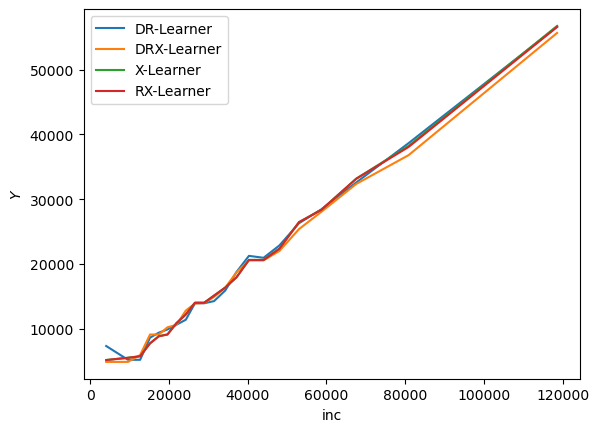

In [36]:
t0 = tau0.predict(Zgrid.values)
t1 = tau1.predict(Zgrid.values)
m = mu.predict_proba(Zgrid.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
tDRX = tauDRX.predict(Zgrid.values)
tRX = tauRX.predict(Zgrid.values) + tX

plt.plot(grid, tDR, label=f'DR-Learner')
plt.plot(grid, tDRX, label=f'DRX-Learner')
plt.plot(grid, tX,  label=f'X-Learner')
plt.plot(grid, tRX, label=f'RX-Learner')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [37]:
# correcting for covariate shift in CATE model estimation in X-Learner
m = mu.predict_proba(Z)[:, 1]

g0 = reg().fit(Z[D==0], Y[D==0], sample_weight=(1 - m[D==0]))
g1 = reg().fit(Z[D==1], Y[D==1], sample_weight=m[D==1])
tau0 = reg().fit(Z[D==0], g1.predict(Z[D==0]) - Y[D==0], sample_weight=m[D==0]**2 / (1 - m[D==0]))
tau1 = reg().fit(Z[D==1], Y[D==1] - g0.predict(Z[D==1]), sample_weight=(1 - m[D==1])**2 / m[D==1])

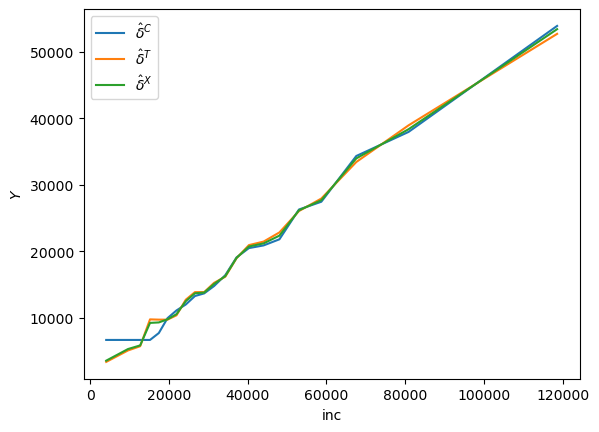

In [38]:
t0 = tau0.predict(Zgrid.values)
t1 = tau1.predict(Zgrid.values)
m = mu.predict_proba(Zgrid.values)[:, 1]
tX = t1 * (1 - m) + t0 * m
plt.plot(grid, t0,  label='$\hat{\delta}^C$')
plt.plot(grid, t1, label='$\hat{\delta}^T$')
plt.plot(grid, tX,  label='$\hat{\delta}^X$')
plt.xlabel(xfeat)
plt.ylabel('$Y$')
plt.legend()
plt.show()

In [35]:
# from sklearn.model_selection import cross_val_predict, KFold

# m = cross_val_predict(clf(), Z, D, method='predict_proba')[:, 1]
# g0preds, g1preds = np.zeros(Y.shape), np.zeros(Y.shape)
# for train, test in KFold().split(Z, D):
#     g1preds[test] = reg().fit(Z[train][D[train]==1], Y[train][D[train]==1]).predict(Z[test])
#     g0preds[test] = reg().fit(Z[train][D[train]==0], Y[train][D[train]==0]).predict(Z[test])

# gpreds = g1preds * D + g0preds * (1 - D)
# Ydr = (Y - gpreds) * (D - m)/(m * (1 - m)) + g1preds - g0preds
# tauDR = reg().fit(Z, Ydr)

In [36]:
# grid = np.linspace(0, 1, 20)

# t0 = tau0.predict(grid.reshape(-1, 1))
# t1 = tau1.predict(grid.reshape(-1, 1))
# tDR = tauDR.predict(grid.reshape(-1, 1))
# m = mu.predict_proba(grid.reshape(-1, 1))[:, 1]
# plt.plot(grid, tDR, label='DR-Learner')
# plt.plot(grid, t1 * (1 - m) + t0 * m,  label='X-Learner')
# plt.xlabel('$Z$')
# plt.ylabel('$Y$')
# plt.legend()
# plt.show()